In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2

In [2]:
plt.rcParams['figure.figsize'] = [6, 8]

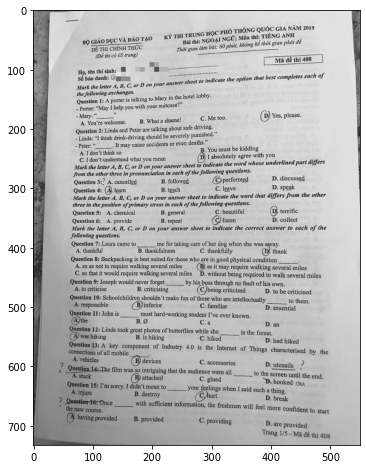

In [3]:
# Chuyển thành ảnh xám
img = cv2.imread('exam2.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

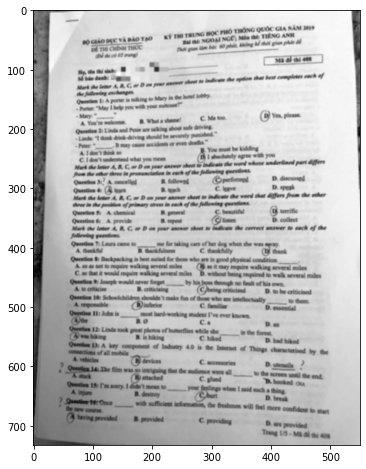

In [4]:
blurred = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

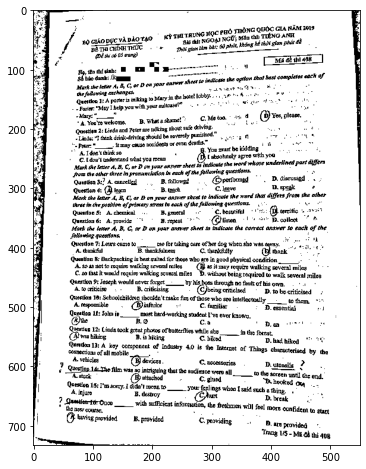

In [5]:
# Chuyển thành ảnh đen trắng bằng Gaussian Threshold 
# (với những phép toán như tìm contour hoặc binary_fill_holes sẽ xử lý hiệu quả hơn trên ảnh đen trắng nên cần có bước này)
im = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)
plt.imshow(im, cmap='gray')

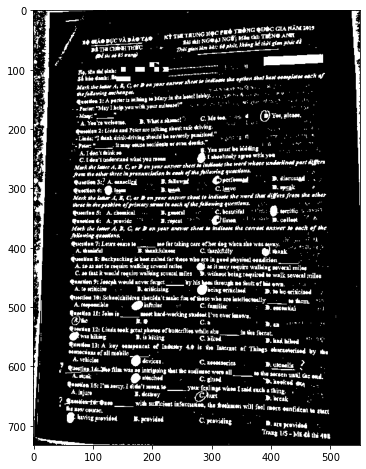

In [6]:
# lấp chỗ trống trong những hình tròn
from scipy.ndimage.morphology import binary_fill_holes

# binary_fill_holes là 1 hàm binary delation
clean_image = binary_fill_holes(255 - im)
plt.imshow(clean_image, cmap='gray')

In [7]:
clean_image = np.float32(clean_image)

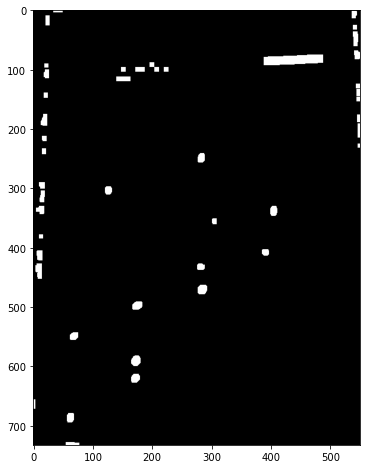

In [8]:
# Opening (mục đích để loại bỏ trường hợp 2 hình tròn dính nhau, hoặc hình tròn dính vào chữ, 
# tuy nhiên opening làm mất dấu khi các hình tròn bị gạch chéo)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
opening = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')

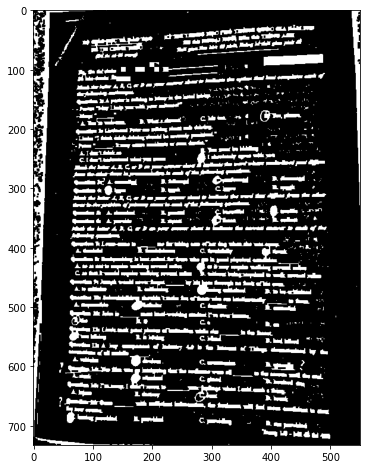

In [9]:
# Closing (thử cho vui thôi, không hiệu quả)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
closing = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

In [10]:
# Lấy ra vị trí các contour (contour là 1 chuỗi tọa độ (x_i, y_) các điểm có cùng độ sáng dọc theo biên của 1 object (t đang hiểu là thế))
contours, _ = cv2.findContours(opening.astype(np.uint8), # pylint: disable=unused-variable
                                  cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_NONE)

# Vẽ contour
obj_image = np.zeros(opening.shape)
for index, cnt in enumerate(contours):
    print(cnt.shape)
    print(cnt)
    cv2.drawContours(opening, [cnt], 0, 255, -1)

(51, 1, 2)
[[[ 55 728]]

 [[ 55 729]]

 [[ 55 730]]

 [[ 55 731]]

 [[ 55 732]]

 [[ 56 732]]

 [[ 57 732]]

 [[ 58 732]]

 [[ 59 732]]

 [[ 60 732]]

 [[ 61 732]]

 [[ 62 732]]

 [[ 63 732]]

 [[ 64 732]]

 [[ 65 732]]

 [[ 66 732]]

 [[ 67 732]]

 [[ 68 732]]

 [[ 69 732]]

 [[ 70 732]]

 [[ 71 732]]

 [[ 72 732]]

 [[ 73 732]]

 [[ 74 732]]

 [[ 75 732]]

 [[ 76 732]]

 [[ 77 732]]

 [[ 77 731]]

 [[ 77 730]]

 [[ 77 729]]

 [[ 76 729]]

 [[ 75 729]]

 [[ 74 729]]

 [[ 73 729]]

 [[ 72 729]]

 [[ 71 729]]

 [[ 70 729]]

 [[ 69 728]]

 [[ 68 728]]

 [[ 67 728]]

 [[ 66 728]]

 [[ 65 728]]

 [[ 64 728]]

 [[ 63 728]]

 [[ 62 728]]

 [[ 61 728]]

 [[ 60 728]]

 [[ 59 728]]

 [[ 58 728]]

 [[ 57 728]]

 [[ 56 728]]]
(45, 1, 2)
[[[ 59 679]]

 [[ 59 680]]

 [[ 58 681]]

 [[ 57 682]]

 [[ 57 683]]

 [[ 57 684]]

 [[ 57 685]]

 [[ 57 686]]

 [[ 57 687]]

 [[ 57 688]]

 [[ 57 689]]

 [[ 57 690]]

 [[ 57 691]]

 [[ 57 692]]

 [[ 58 693]]

 [[ 58 694]]

 [[ 59 694]]

 [[ 60 694]]

 [[ 61 694]]

In [11]:
class points:  
    def __init__(self, cx, cy):  
        self.cx = cx 
        self.cy = cy 

Ta có công thức $\frac{4\pi^2r^2}{C^2}=1$ trong đó $C$ là chu vi của hình tròn, giờ ta xác định giá trị $\alpha=\frac{4\pi area}{P^2}$ với $P$ là chu vi của `contour` và nếu giá trị $\alpha$ lớn hơn hoặc bằng `round_thresh` thì ta chấp nhận `contour` đấy là vòng tròn. Ngoài ra trong ảnh các chữ cái cũng có thể tạo thành contour với `area` nhỏ, nên cần phải có một `threshold` nữa cho `area`

62 686
171 619
172 590
175 497
284 470
404 338
18 185


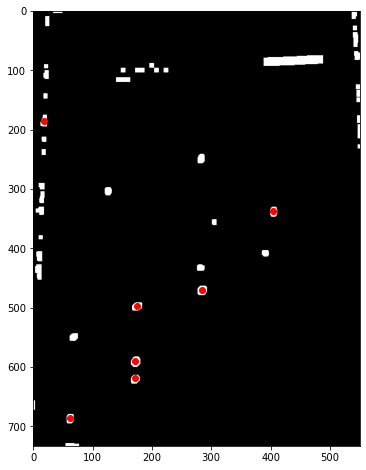

In [12]:
import matplotlib.pyplot as plt

round_thresh = 0.6

plt.figure()
height, width = obj_image.shape
plt.imshow(opening.astype(np.uint8), cmap='gray')
areas = []
alphas = []
pointsA = [] 

# print('Object      Area Perimeter Roundness')
for ind, contour in enumerate(contours):
    # tính chu vi của contour
    perimeter = cv2.arcLength(contour, True)
    # tính diện tích của contour
    area = cv2.contourArea(contour)
    areas.append(area)
    
    # nếu như chu vi bằng 0 hoặc area nhỏ hơn threshold thì ta đặt ngay góc alpha = 0
    if perimeter==0 or area<150:
        alpha = 0
    else:
        alpha = 4*np.pi*area/(perimeter**2)
        alphas.append(alpha)

    # Vẽ vòng tròn đỏ tại tâm của contour thỏa mãn điều kiện là vòng tròn
    if alpha > round_thresh:
        moments = cv2.moments(contour)
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        pointsA.append(points(cx, cy));
        print(cx,cy)
        plt.plot(cx, cy, 'ro')
        

axes = plt.gca()
axes.set_xlim([0, width])
axes.set_ylim([height, 0])

plt.show()

In [13]:
import pytesseract

7


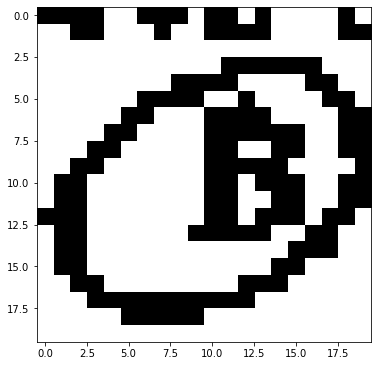

In [50]:
h = 10
print(len(pointsA))
i=3
crop_img = im[pointsA[i].cy-h:pointsA[i].cy+h, pointsA[i].cx-h:pointsA[i].cx+h]
plt.imshow(crop_img, cmap='gray')

In [15]:
crop_img2 = cv2.fastNlMeansDenoising(crop_img,10,10,7,21);

In [16]:
arrayTemplate = []

In [17]:
templateA = cv2.imread('exam2_A.png', cv2.IMREAD_GRAYSCALE)
templateA = cv2.adaptiveThreshold(templateA,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)
templateB = cv2.imread('exam2_B.png', cv2.IMREAD_GRAYSCALE)
templateB = cv2.adaptiveThreshold(templateB,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)
templateC = cv2.imread('exam2_C.png', cv2.IMREAD_GRAYSCALE)
templateC = cv2.adaptiveThreshold(templateC,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)
templateD = cv2.imread('exam2_D.png', cv2.IMREAD_GRAYSCALE)
templateD = cv2.adaptiveThreshold(templateD,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)

arrayTemplate.append(templateA)
arrayTemplate.append(templateB)
arrayTemplate.append(templateC)
arrayTemplate.append(templateD)

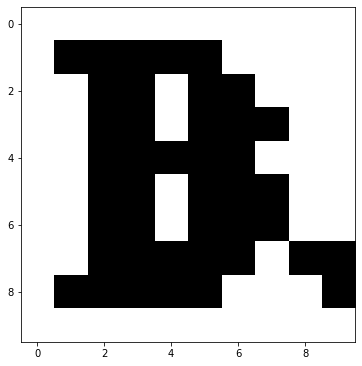

In [33]:
dim=(10,10)
templateC = cv2.resize(templateC, dim, interpolation = cv2.INTER_AREA)
plt.imshow(templateB, cmap='gray')

In [52]:
check =0 
arrayresult=[]
h = 10
dem=0
for obj in pointsA: 
    crop_img = im[obj.cy-h:obj.cy+h, obj.cx-h:obj.cx+h]
    for i in range(len(arrayTemplate)):
        result = cv2.matchTemplate(crop_img,arrayTemplate[i], cv2.TM_CCOEFF_NORMED)
        loc = np.where( result >= 0.6)
        print(loc)
        for pt in zip(*loc[::-1]):
            arrayresult.append(i)
            check = 1
    print(dem)
    if (check == 0):
        arrayresult.append(-1)
    dem += 1
    check=0
   



(array([4], dtype=int64), array([10], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
0
(array([], dtype=int64), array([], dtype=int64))
(array([5], dtype=int64), array([9], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
1
(array([], dtype=int64), array([], dtype=int64))
(array([6], dtype=int64), array([9], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
2
(array([], dtype=int64), array([], dtype=int64))
(array([5], dtype=int64), array([8], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
3
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([6], dtype=int64), array([6], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
4

Với 0 là A
    1 là B
    2 là C
    3 là D

In [54]:
print(arrayresult)

[0, 1, 1, 1, 2, 3, -1]


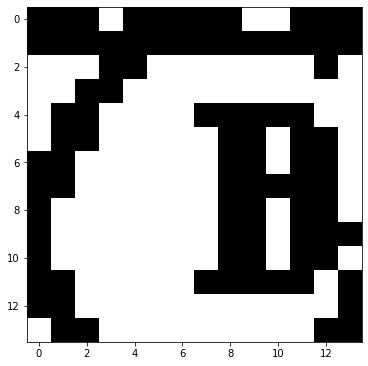

In [21]:
w = h = 5;
for pt in zip(*loc[::-1]):
    cv2.rectangle(crop_img, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)

plt.imshow(crop_img2, cmap='gray')

In [22]:
import numpy as np

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [23]:
crop_img3 = cv2.adaptiveThreshold(crop_img2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,7)


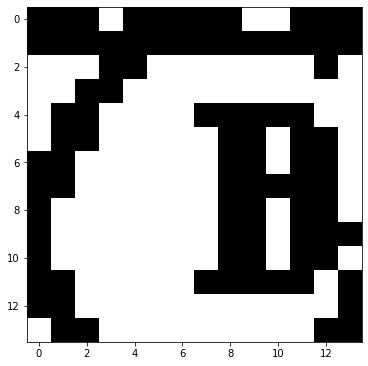

In [24]:
plt.imshow(crop_img3, cmap='gray')


In [25]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Users\\NgoThinh\\AppData\\Local\\Tesseract-OCR\\tesseract.exe'

In [26]:
print(pytesseract.image_to_string(crop_img3))

In [27]:
n = 6
  
alphas.sort()
areas.sort() 
print(areas[-n:]) 
print(alphas[-n:])

[169.0, 180.5, 202.0, 207.5, 211.5, 1358.0]
[0.8407296784365829, 0.8512533161442724, 0.8533412935298077, 0.8855771134235453, 0.9046739074425667, 0.9100460184601844]
